<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Algorithmic Trading

**Chapter 04 &mdash; Vectorized Backtesting**

## Making Use of Vectorization

### Vectorization with NumPy 

In [52]:
%config InlineBackend.figure_format = 'retina'

In [53]:
v = [1, 2, 3, 4, 5]

In [54]:
sm = [2 * i for i in v]

In [55]:
sm

[2, 4, 6, 8, 10]

In [56]:
2 * v

[1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

In [57]:
import numpy as np

In [58]:
a = np.array(v)

In [59]:
a

array([1, 2, 3, 4, 5])

In [60]:
type(a)

numpy.ndarray

In [61]:
2 * a

array([ 2,  4,  6,  8, 10])

In [62]:
0.5 * a + 2

array([2.5, 3. , 3.5, 4. , 4.5])

In [63]:
a = np.arange(12).reshape((4, 3))

In [64]:
a

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [65]:
2 * a

array([[ 0,  2,  4],
       [ 6,  8, 10],
       [12, 14, 16],
       [18, 20, 22]])

In [66]:
a ** 2

array([[  0,   1,   4],
       [  9,  16,  25],
       [ 36,  49,  64],
       [ 81, 100, 121]])

In [67]:
a.mean()

5.5

In [68]:
np.mean(a)

5.5

In [69]:
a.mean(axis=0)

array([4.5, 5.5, 6.5])

In [70]:
np.mean(a, axis=1)

array([ 1.,  4.,  7., 10.])

### Vectorization with pandas

In [71]:
a = np.arange(15).reshape(5, 3)

In [72]:
a

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

In [73]:
import pandas as pd

In [74]:
columns = list('abc')

In [75]:
columns

['a', 'b', 'c']

In [76]:
index = pd.date_range('2021-7-1', periods=5, freq='B')

In [77]:
index

DatetimeIndex(['2021-07-01', '2021-07-02', '2021-07-05', '2021-07-06',
               '2021-07-07'],
              dtype='datetime64[ns]', freq='B')

In [78]:
df = pd.DataFrame(a, columns=columns, index=index)

In [79]:
df

,a,b,c
2021-07-01,0,1,2
2021-07-02,3,4,5
2021-07-05,6,7,8
2021-07-06,9,10,11
2021-07-07,12,13,14


In [80]:
2 * df

,a,b,c
2021-07-01,0,2,4
2021-07-02,6,8,10
2021-07-05,12,14,16
2021-07-06,18,20,22
2021-07-07,24,26,28


In [81]:
df.sum()

a    30
b    35
c    40
dtype: int64

In [82]:
np.mean(df)

7.0

In [83]:
df['a'] + df['c']

2021-07-01     2
2021-07-02     8
2021-07-05    14
2021-07-06    20
2021-07-07    26
Freq: B, dtype: int64

In [84]:
0.5 * df.a + 2 * df.b - df.c

2021-07-01     0.0
2021-07-02     4.5
2021-07-05     9.0
2021-07-06    13.5
2021-07-07    18.0
Freq: B, dtype: float64

In [85]:
df['a'] > 5

2021-07-01    False
2021-07-02    False
2021-07-05     True
2021-07-06     True
2021-07-07     True
Freq: B, Name: a, dtype: bool

In [86]:
df[df['a'] > 5]

,a,b,c
2021-07-05,6,7,8
2021-07-06,9,10,11
2021-07-07,12,13,14


In [87]:
df['c'] > df['b']

2021-07-01    True
2021-07-02    True
2021-07-05    True
2021-07-06    True
2021-07-07    True
Freq: B, dtype: bool

In [88]:
0.15 * df.a + df.b > df.c

2021-07-01    False
2021-07-02    False
2021-07-05    False
2021-07-06     True
2021-07-07     True
Freq: B, dtype: bool

## Strategies based on Simple Moving Averages

### Getting into the Basics 

In [89]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                   index_col=0, parse_dates=True).dropna()

*this data is from Refinitif Eikon Data API and represents EOD (end-of-day) values for the respective instruments (RICs)*

In [90]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [91]:
data = pd.DataFrame(raw['EUR=']) # Transform the Series object to a DataFrame object

In [92]:
data.rename(columns={'EUR=': 'price'}, inplace=True) # Rename the only column to 'price'

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [94]:
data['SMA1'] = data['price'].rolling(42).mean() # Create a column with 42 days of SMA values. The first 41 values are NaN

In [95]:
data['SMA2'] = data['price'].rolling(252).mean() # Create a column with 252 days of SMA values. The first 251 values are NaN

In [96]:
data.tail()

,price,SMA1,SMA2
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


In [97]:
%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'

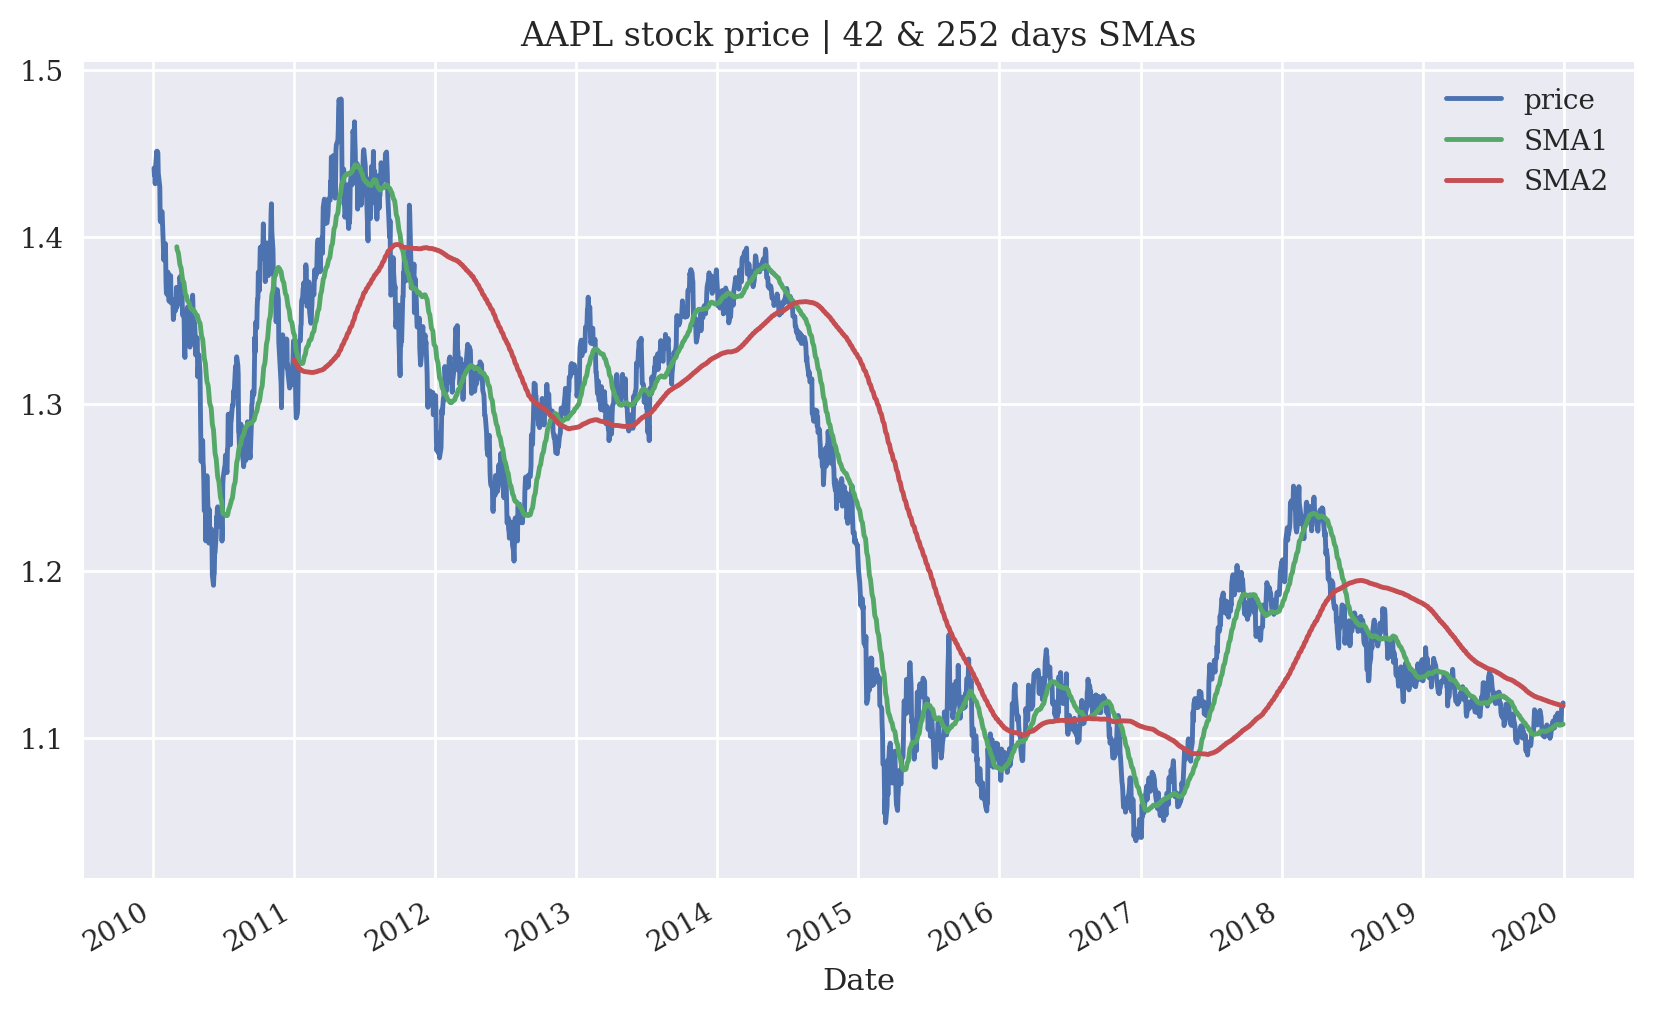

In [98]:
# The EUR/USD exchange rate with 42 and 252 days SMAs
data.plot(title='AAPL stock price | 42 & 252 days SMAs',
          figsize=(10, 6));

In [99]:
# Implements the trading rule in vectorized fashion. np.where() produces +1 for row where the expression is True and -1 for rows where the expression is False
data['position'] = np.where(data['SMA1'] > data['SMA2'],
                            1, -1)

In [100]:
data.dropna(inplace=True) # Drop the rows with NaN values

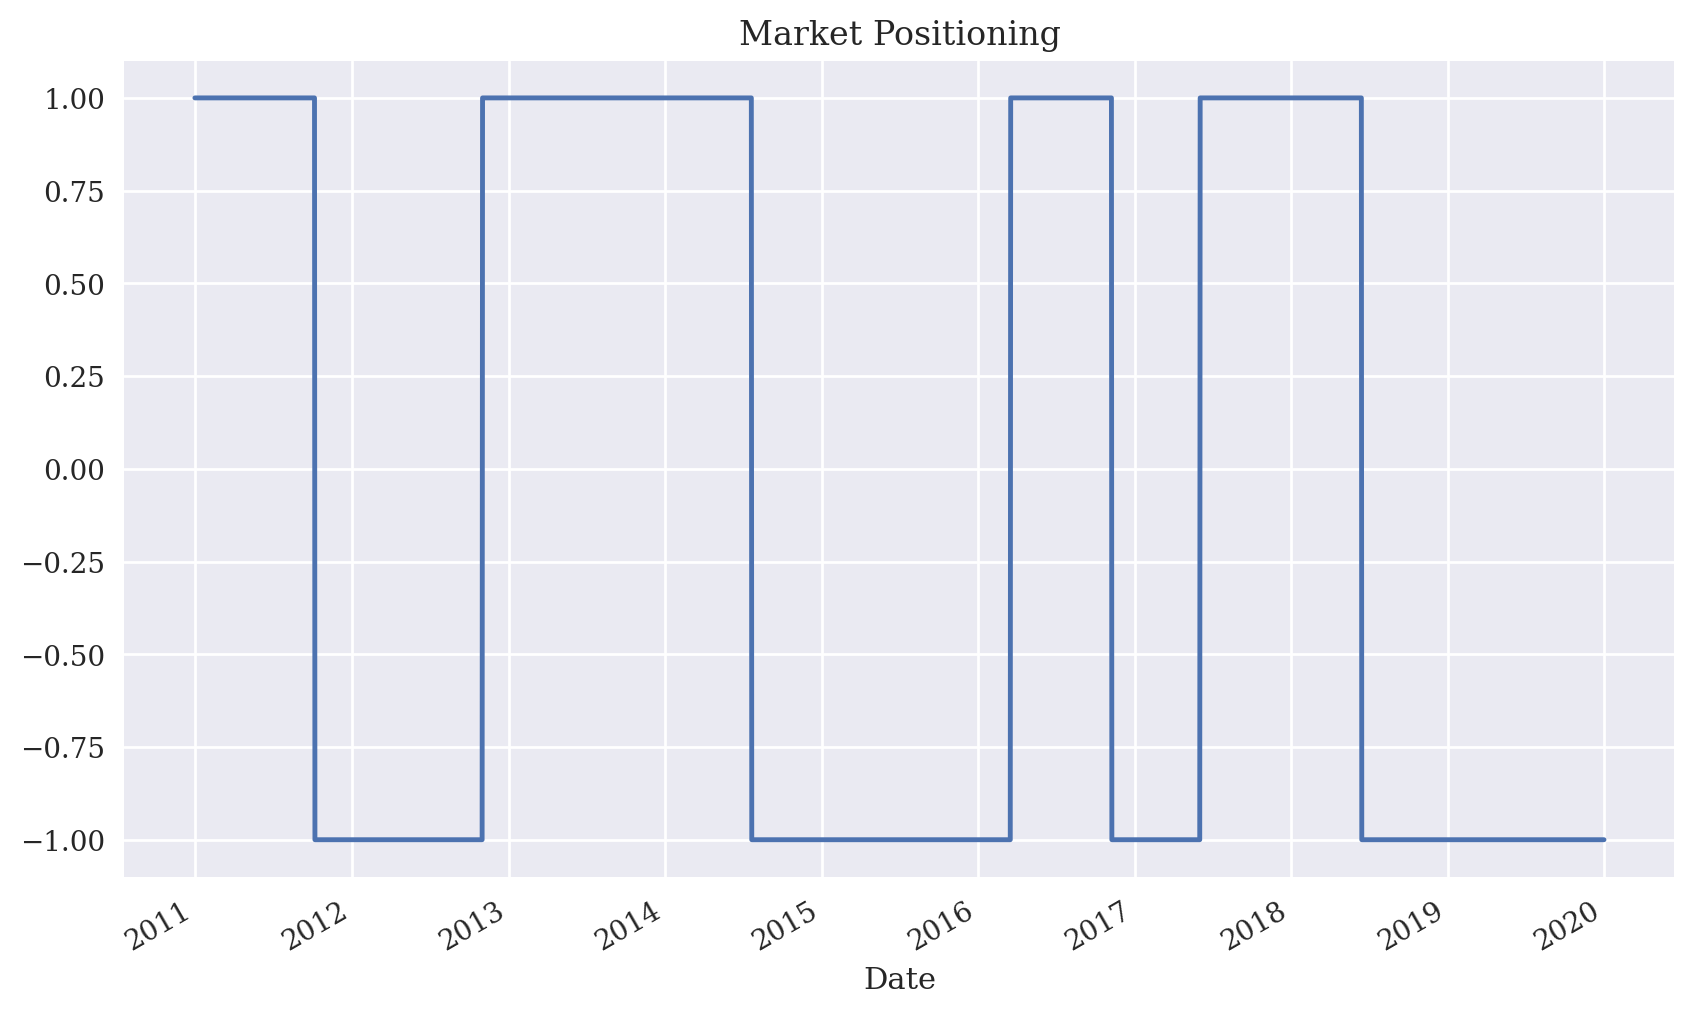

In [101]:
# Plot the market positioning over time
data['position'].plot(ylim=[-1.1, 1.1],
                      title='Market Positioning',
                      figsize=(10, 6));

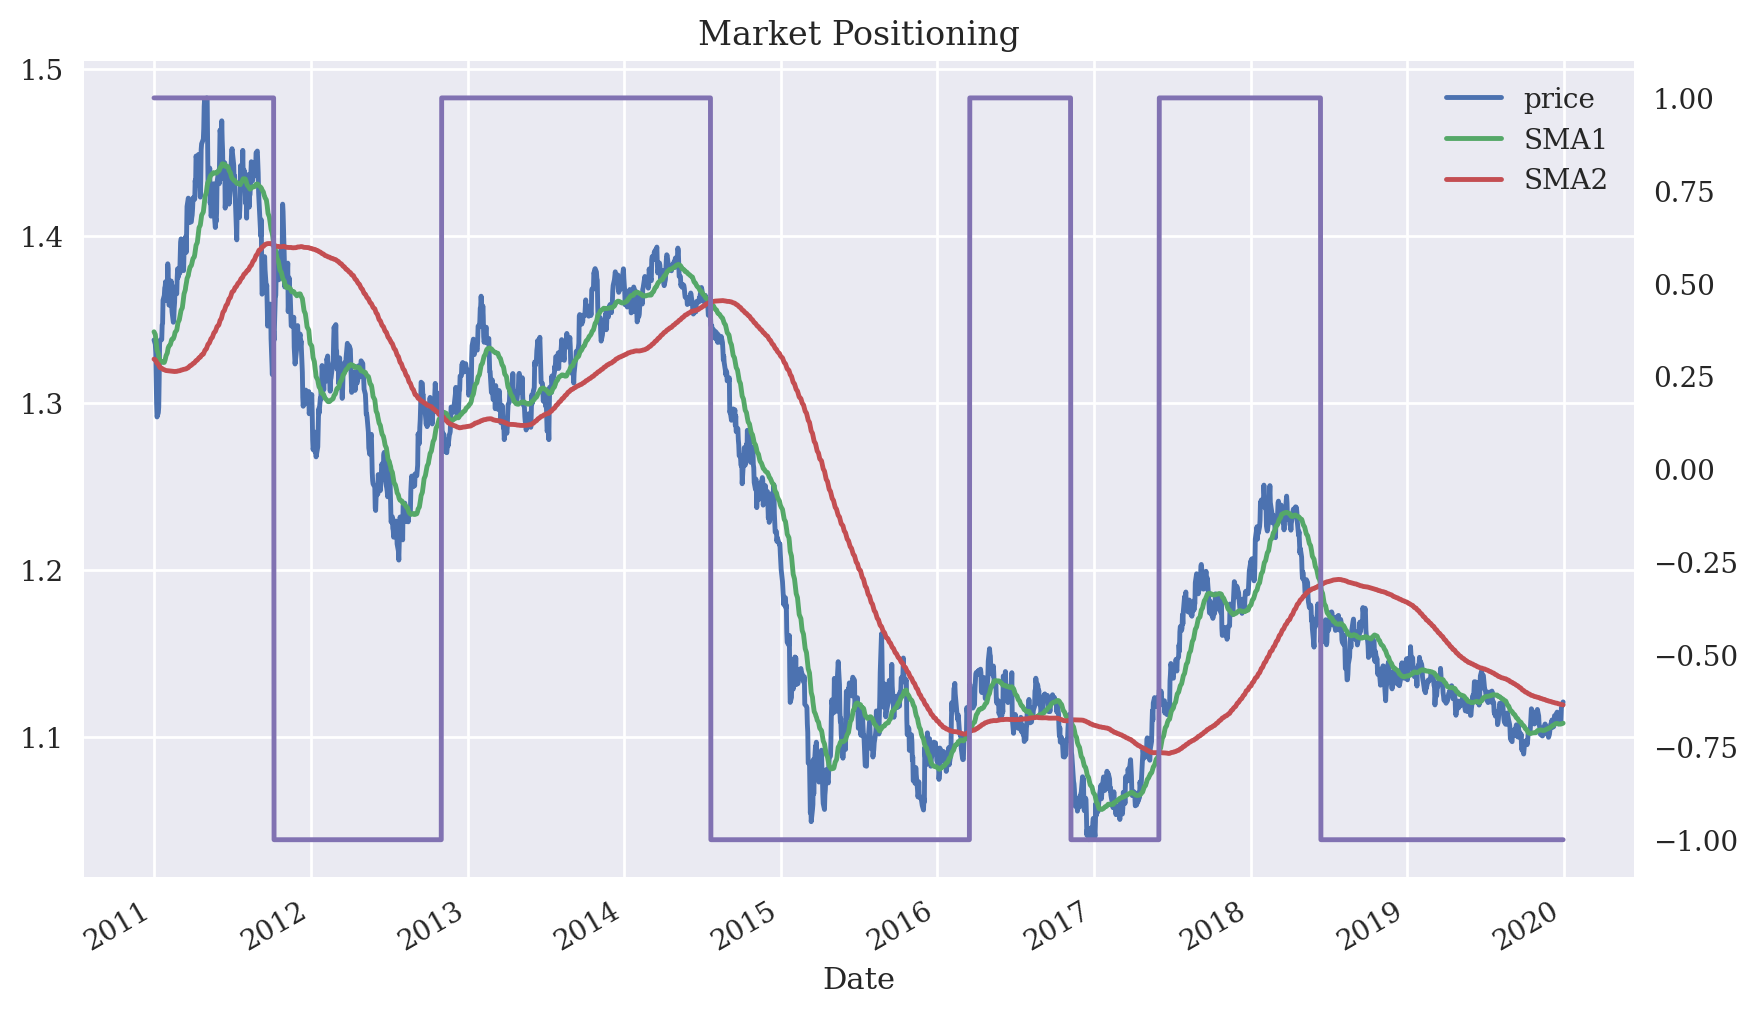

In [103]:
# The EUR/USD exchange rate with 42 and 252 days SMAs combined with the market positioning
# need to use the secondary_y parameter to plot the market positioning on the right y-axis
data[['price', 'SMA1', 'SMA2']].plot(title='AAPL stock price | 42 & 252 days SMAs',
                                     figsize=(10, 6));
data['position'].plot(ylim=[-1.1, 1.1], secondary_y='position',
                        title='Market Positioning',
                        figsize=(10, 6));

To calculate the performance of the strategy, calculate the log returns based on the original financial time series next.

In [104]:
# Calculates the log returns in vectorized fashion over the price colummn
data['returns'] = np.log(data['price'] / data['price'].shift(1))

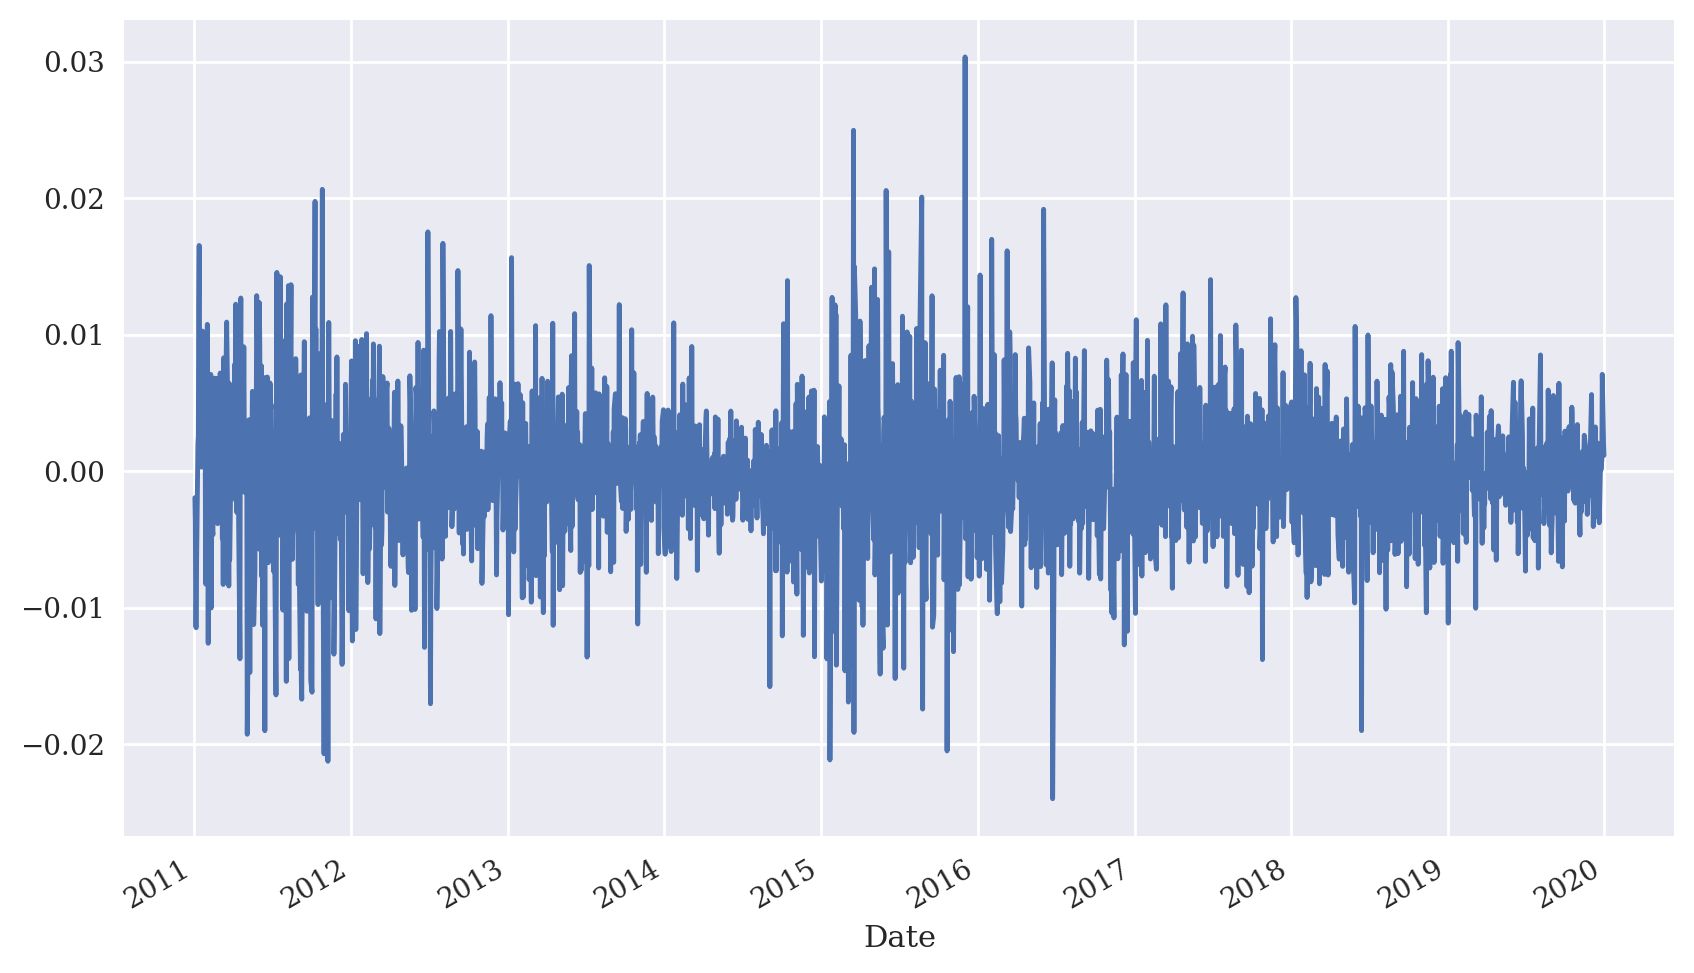

In [106]:
# plots the log returns over time
data['returns'].plot(figsize=(10, 6));

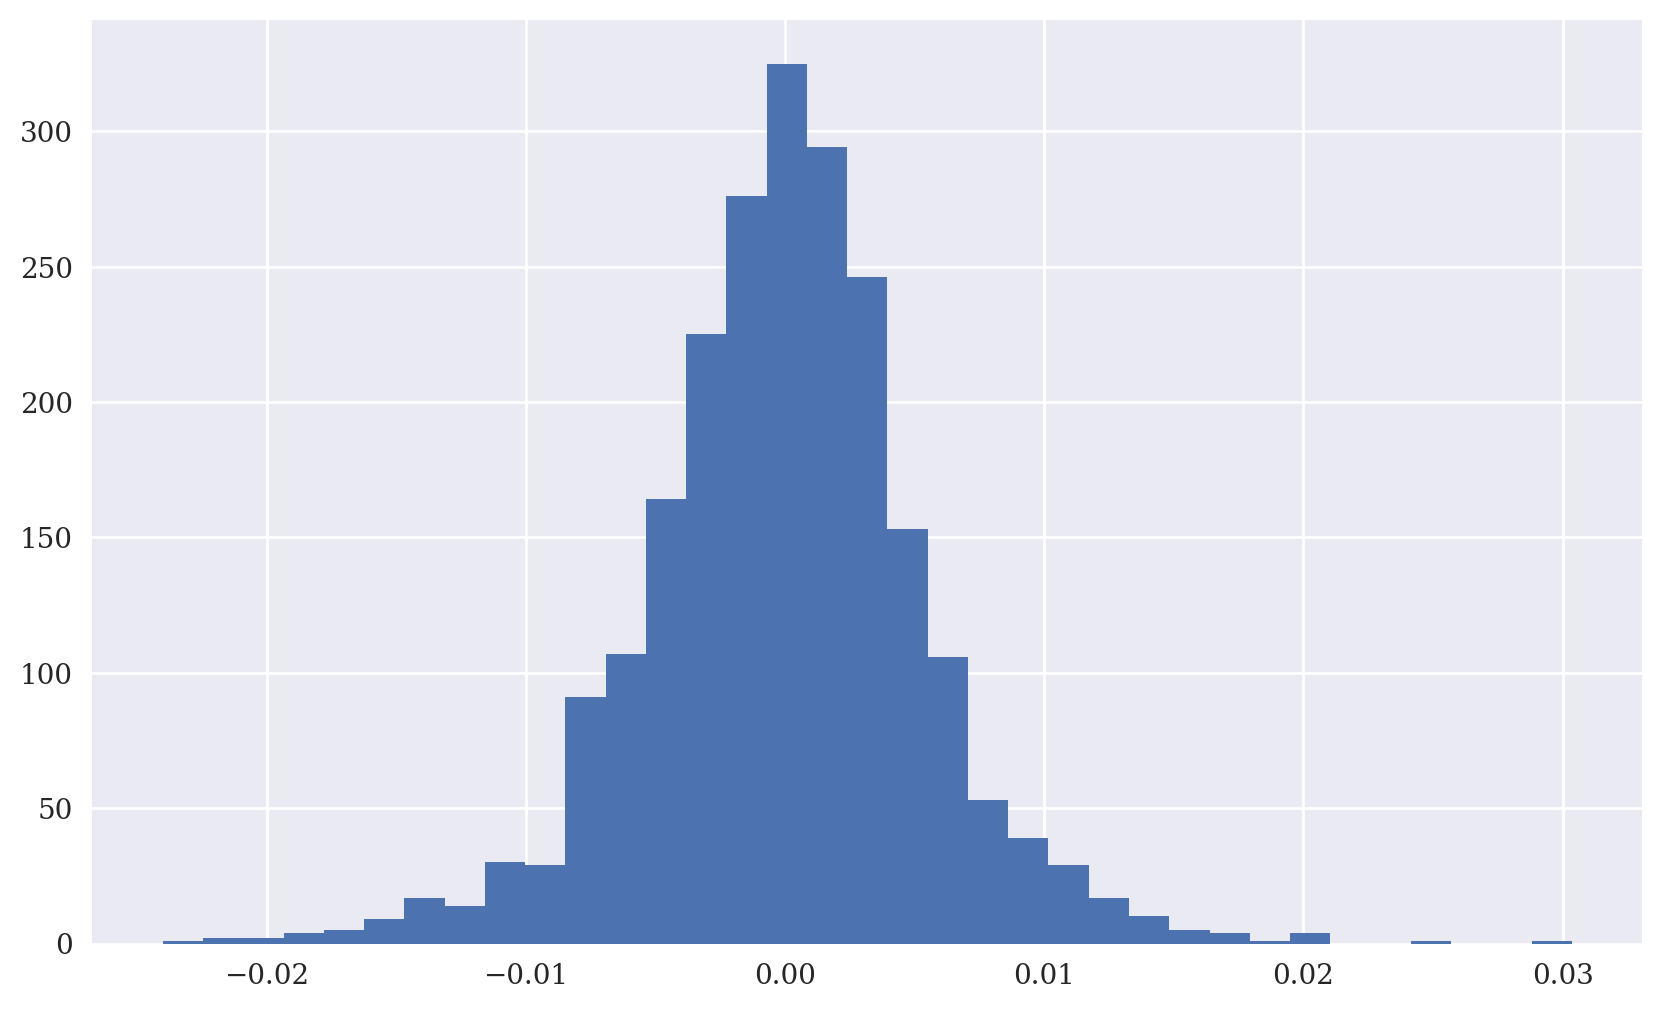

In [105]:
# Plot the log returns as a histogram (frequency distribution)
data['returns'].hist(bins=35, figsize=(10, 6));

> To derive the strategy return, multiply the position column - shifted by one trading day - with the return column.
> Since log returns are additive, calculating the sum over the columns `returns` and `strategy` provides a first comparison of the performance of the strategy relative to the base investment itself.
---
> Note:
>
> `shift(1)`: This method shifts the position column down by one row. This operation is often used in financial time series analysis to ensure that you're using only past information (i.e., the position you decided to take at the end of the previous period) to calculate the current period's returns. It prevents lookahead bias, which occurs when a model uses information not available at the time of prediction.
---

*Comparing the returns shows that the strategy books a win over the passive benchmark investment:*

In [107]:
# derives the log returns of the strategy
# given the positionings and market returns
data['strategy'] = data['position'].shift(1) * data['returns']

In [108]:
data[['returns', 'strategy']].sum() # Calculate the sum of the returns and the strategy

returns    -0.176731
strategy    0.253121
dtype: float64

In [109]:
# applies the exponential function to the sum of the log returns to calculate the gross performance.
data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.838006
strategy    1.288039
dtype: float64

*Calculating the cummulative sum over time with `cumsum` and, based on this, the cummulative returns by applying the exponential function `np.exp()` gives a more comprehensive picture of how the strategy compares to the performance of the base financial instrument over time. The figure below shows the data graphically and illustrates the outperformances in this particular case*

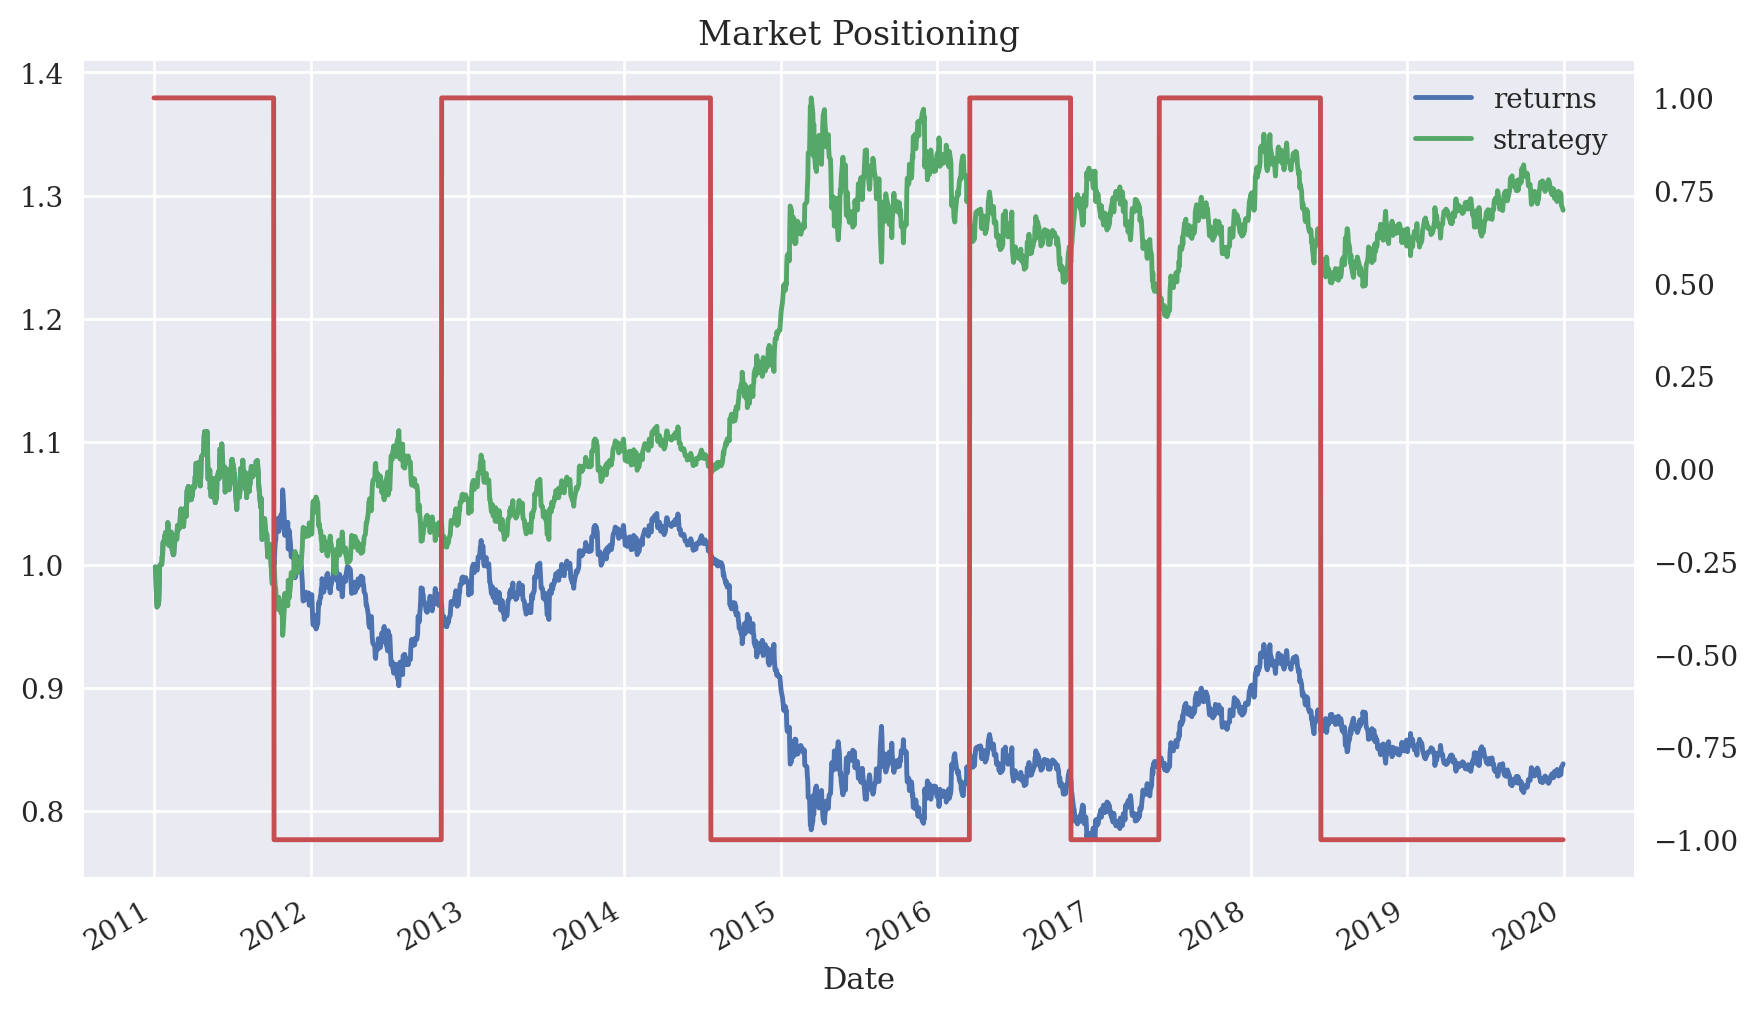

In [113]:
data[['returns', 'strategy']].dropna().cumsum(
            ).apply(np.exp).plot(figsize=(10, 6))

data['position'].plot(ylim=[-1.1, 1.1], secondary_y='position',
                        title='Market Positioning',
                        figsize=(10, 6))

In [ ]:
data[['returns', 'strategy']].mean() * 252

In [ ]:
data[['returns', 'strategy']].std() * 252 ** 0.5

In [ ]:
data['cumret'] = data['strategy'].cumsum().apply(np.exp)

In [ ]:
data['cummax'] = data['cumret'].cummax()

In [ ]:
data[['cumret', 'cummax']].dropna().plot(figsize=(10, 6));

In [ ]:
drawdown = data['cummax'] - data['cumret']

In [ ]:
drawdown.max()

In [ ]:
temp = drawdown[drawdown == 0]

In [ ]:
periods = (temp.index[1:].to_pydatetime() -
           temp.index[:-1].to_pydatetime())

In [ ]:
periods[12:15]

In [ ]:
periods.max()

### Generalizing the Approach

In [ ]:
import SMAVectorBacktester as SMA

In [ ]:
smabt = SMA.SMAVectorBacktester('EUR=', 42, 252,
                                '2010-1-1', '2019-12-31') 

In [ ]:
smabt.run_strategy()

In [ ]:
%%time
smabt.optimize_parameters((30, 50, 2),
                          (200, 300, 2))

In [ ]:
smabt.plot_results()

## Strategies based on Momentum

### Getting into the Basics

In [ ]:
data = pd.DataFrame(raw['XAU='])

In [ ]:
data.rename(columns={'XAU=': 'price'}, inplace=True)

In [ ]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))

In [ ]:
data['position'] = np.sign(data['returns'])

In [ ]:
data['strategy'] = data['position'].shift(1) * data['returns']

In [ ]:
data[['returns', 'strategy']].dropna().cumsum(
            ).apply(np.exp).plot(figsize=(10, 6));

In [ ]:
data['position'] = np.sign(data['returns'].rolling(3).mean())

In [ ]:
data['strategy'] = data['position'].shift(1) * data['returns']

In [ ]:
data[['returns', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

#### Intraday Data from Eikon

In [ ]:
fn = '../data/AAPL_1min_05052020.csv'
# fn = '../data/SPX_1min_05052020.csv'

In [ ]:
data = pd.read_csv(fn, index_col=0, parse_dates=True)

In [ ]:
data.info()

In [ ]:
data['returns'] = np.log(data['CLOSE'] /
                         data['CLOSE'].shift(1))

In [ ]:
to_plot = ['returns']

In [ ]:
for m in [1, 3, 5, 7, 9]:
    data['position_%d' % m] = np.sign(data['returns'].rolling(m).mean())
    data['strategy_%d' % m] = (data['position_%d' % m].shift(1) *
                               data['returns'])
    to_plot.append('strategy_%d' % m) 

In [ ]:
data[to_plot].dropna().cumsum().apply(np.exp).plot(
    title='AAPL intraday 05. May 2020',
    figsize=(10, 6), style=['-', '--', '--', '--', '--', '--']);

### Generalizing the Approach

In [ ]:
import MomVectorBacktester as Mom

In [ ]:
mombt = Mom.MomVectorBacktester('XAU=', '2010-1-1',
                                '2019-12-31', 10000, 0.0)

In [ ]:
mombt.run_strategy(momentum=3)

In [ ]:
mombt.plot_results()

In [ ]:
mombt = Mom.MomVectorBacktester('XAU=', '2010-1-1',
                                '2019-12-31', 10000, 0.001)

In [ ]:
mombt.run_strategy(momentum=3)

In [ ]:
mombt.plot_results()

## Strategies based on Mean-Reversion

### Getting into the Basics

In [ ]:
data = pd.DataFrame(raw['GDX'])

In [ ]:
data.rename(columns={'GDX': 'price'}, inplace=True)

In [ ]:
data['returns'] = np.log(data['price'] /
                         data['price'].shift(1))

In [ ]:
SMA = 25

In [ ]:
data['SMA'] = data['price'].rolling(SMA).mean()

In [ ]:
threshold = 3.5

In [ ]:
data['distance'] = data['price'] - data['SMA']

In [ ]:
data['distance'].dropna().plot(figsize=(10, 6), legend=True)
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color='r');

In [ ]:
data['position'] = np.where(data['distance'] > threshold,
                            -1, np.nan)

In [ ]:
data['position'] = np.where(data['distance'] < -threshold,
                            1, data['position'])

In [ ]:
data['position'] = np.where(data['distance'] *
            data['distance'].shift(1) < 0, 0, data['position'])

In [ ]:
data['position'] = data['position'].ffill().fillna(0)

In [ ]:
data['position'].iloc[SMA:].plot(ylim=[-1.1, 1.1],
                               figsize=(10, 6));

In [ ]:
data['strategy'] = data['position'].shift(1) * data['returns']

In [ ]:
data[['returns', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

### Generalizing the Approach 

In [ ]:
import MRVectorBacktester as MR

In [ ]:
mrbt = MR.MRVectorBacktester('GLD', '2010-1-1', '2019-12-31',
                             10000, 0.001)

In [ ]:
mrbt.run_strategy(SMA=43, threshold=7.5)

In [ ]:
mrbt.plot_results()

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>